# Machine Learning & Computational Statistics Project
## Kalemkeridis Evangelos Rafail


## Step 1: Spectral Unmixing

We perform unmixing for each pixel with a nonzero label using five methods:
1. **Least Squares (LS)**
2. **Least Squares with Sum-to-One Constraint**
3. **Least Squares with Non-Negativity Constraint**
4. **Least Squares with Both Constraints**
5. **LASSO (L1 Regularization)**

For each method, we:
- Derive the abundance maps for each endmember.
- Compute the reconstruction error.

Reconstruction error (Least Squares): 35058.8807
Reconstruction error (LS with Sum-to-One): 43082.5763
Reconstruction error (LS with Non-Negativity): 156104.1822
Reconstruction error (LS with Both Constraints): 731259.4089
Reconstruction error (LASSO): 373.0153


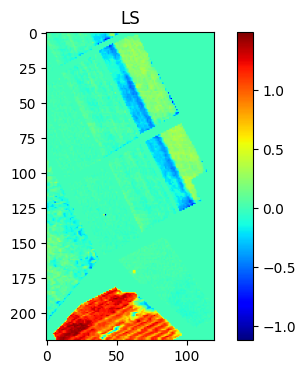

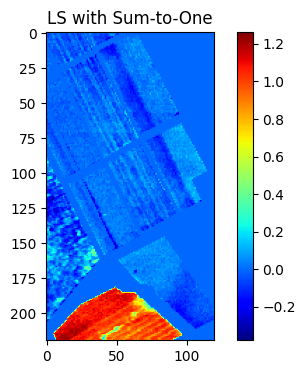

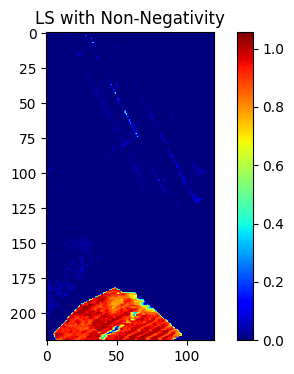

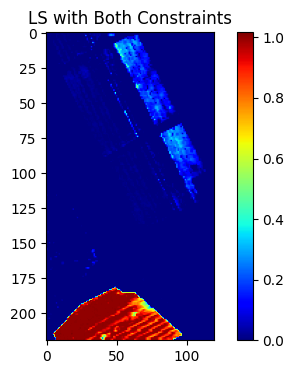

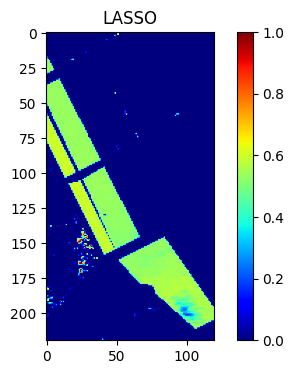

In [19]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import nnls, minimize
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler  # Added for scaling

# Load Hyperspectral Image
Salinas = sio.loadmat('Salinas_cube.mat')
HSI = Salinas['salinas_cube']

# Load endmembers 
ends = sio.loadmat('Salinas_endmembers.mat')
endmembers = ends['salinas_endmembers']

# Load ground truth labels
ground_truth = sio.loadmat('Salinas_gt.mat')
labels = ground_truth['salinas_gt']

# Extract pixels with non zero labels
nonzero_indices = np.nonzero(labels)
nonzero_pixels = HSI[nonzero_indices[0], nonzero_indices[1], :] 
num_pixels = nonzero_pixels.shape[0]
num_endmembers = endmembers.shape[1]

# Initialize Abundance Maps for all methods
abundance_maps_ls = np.zeros((num_pixels, num_endmembers))  # Least Squares
abundance_maps_ls_sum = np.zeros((num_pixels, num_endmembers))  # LS with Sum-to-One
abundance_maps_ls_nonneg = np.zeros((num_pixels, num_endmembers))  # LS with Non-Negativity
abundance_maps_ls_both = np.zeros((num_pixels, num_endmembers))  # LS with Both Constraints
abundance_maps_lasso = np.zeros((num_pixels, num_endmembers))  # LASSO

# Method 1 - Least Squares
for i in range(num_pixels): 
    y = nonzero_pixels[i, :]
    X = endmembers
    theta = np.linalg.lstsq(X, y, rcond=None)[0]
    abundance_maps_ls[i, :] = theta

# Method 2 - Least Squares with Sum-to-One Constraint
def sum_to_one_constraint(theta): 
    return np.sum(theta) - 1

for i in range(num_pixels):
    y = nonzero_pixels[i, :]
    X = endmembers
    res = minimize(lambda theta: np.linalg.norm(y - X @ theta),
                   x0=np.ones(num_endmembers) / num_endmembers,
                   constraints={'type' : 'eq', 'fun' : sum_to_one_constraint})
    abundance_maps_ls_sum[i, :] = res.x

# Method 3 - Least Squares with Non-Negativity Constraint
for i in range(num_pixels):
    y = nonzero_pixels[i, :]
    X = endmembers
    theta, _ = nnls(X,y)
    abundance_maps_ls_nonneg[i, :] = theta

# Method 4 - Least Squares with Both Constraints
def both_constraints(theta):
    return np.sum(theta) - 1

for i in range(num_pixels):
    y = nonzero_pixels[i, :]
    X = endmembers
    res = minimize(lambda theta: np.linalg.norm(y - X @ theta),
                   x0=np.ones(num_endmembers) / num_endmembers,
                   constraints={'type' : 'eq', 'fun' : both_constraints},
                   bounds=[(0, None)] * num_endmembers)
    abundance_maps_ls_both[i, :] = res.x

# Standardize endmembers for LASSO
scaler = StandardScaler()
scaler_y = StandardScaler()  
X_scaled = scaler.fit_transform(endmembers)
y_scaled = scaler_y.fit_transform(nonzero_pixels)  

# Method 5 - LASSO
lasso = Lasso(alpha=0.005, max_iter=50000, tol=1e-3, warm_start=True, selection='random', fit_intercept=False)  
for i in range(num_pixels):
    y  = nonzero_pixels[i, :]
    lasso.fit(X_scaled, y_scaled[i])  
    abundance_maps_lasso[i, :] = np.maximum(0, lasso.coef_)
    abundance_maps_lasso[i, :] /= np.sum(abundance_maps_lasso[i, :]) if np.sum(abundance_maps_lasso[i, :]) > 0 else 1  

# Compute reconstruction error 
def compute_reconstruction_error_vectorized(abundance_map, endmembers, nonzero_pixels):
    """Compute the mean squared error between reconstructed and original spectra."""
    reconstructed = abundance_map @ endmembers.T  
    error = np.mean(np.linalg.norm(nonzero_pixels - reconstructed, axis=1) ** 2)  
    return error


# Calculate reconstruction errors
error_ls = compute_reconstruction_error_vectorized(abundance_maps_ls, endmembers, nonzero_pixels)
error_ls_sum = compute_reconstruction_error_vectorized(abundance_maps_ls_sum, endmembers, nonzero_pixels)
error_ls_nonneg = compute_reconstruction_error_vectorized(abundance_maps_ls_nonneg, endmembers, nonzero_pixels)
error_ls_both = compute_reconstruction_error_vectorized(abundance_maps_ls_both, endmembers, nonzero_pixels)
error_lasso = compute_reconstruction_error_vectorized(abundance_maps_lasso, X_scaled, y_scaled)  

# Print reconstruction errors
print(f"Reconstruction error (Least Squares): {error_ls:.4f}")
print(f"Reconstruction error (LS with Sum-to-One): {error_ls_sum:.4f}")
print(f"Reconstruction error (LS with Non-Negativity): {error_ls_nonneg:.4f}")
print(f"Reconstruction error (LS with Both Constraints): {error_ls_both:.4f}")
print(f"Reconstruction error (LASSO): {error_lasso:.4f}")

# Fix Abundance Map Plotting
def plot_abundance_map_fixed(abundance_map, title, labels, nonzero_indices):
    """Fixes abundance map reshaping issue."""
    abundance_map_reshaped = np.zeros_like(labels, dtype=float)
    
    for idx, (x, y) in enumerate(zip(nonzero_indices[0], nonzero_indices[1])):
        abundance_map_reshaped[x, y] = abundance_map[idx, 0]  

    plt.figure(figsize=(6, 4))
    plt.imshow(abundance_map_reshaped, cmap='jet')
    plt.title(title)
    plt.colorbar()
    plt.show()

# Plot Corrected Abundance Maps
plot_abundance_map_fixed(abundance_maps_ls, 'LS', labels, nonzero_indices)
plot_abundance_map_fixed(abundance_maps_ls_sum, 'LS with Sum-to-One', labels, nonzero_indices)
plot_abundance_map_fixed(abundance_maps_ls_nonneg, 'LS with Non-Negativity', labels, nonzero_indices)
plot_abundance_map_fixed(abundance_maps_ls_both, 'LS with Both Constraints', labels, nonzero_indices)
plot_abundance_map_fixed(abundance_maps_lasso, 'LASSO', labels, nonzero_indices)


# Spectral Unmixing Performance Evaluation

## Reconstruction Errors

| **Method**                                | **Reconstruction Error** |
|-------------------------------------------|--------------------------|
| Least Squares (LS)                        | 35,058.8807              |
| LS with Sum-to-One Constraint             | 43,082.5763              |
| LS with Non-Negativity Constraint         | 156,104.1822             |
| LS with Both Constraints                  | 731,259.4089             |
| LASSO                                      | 373.0178                 |

### Observations:
- **Least Squares (LS)** achieves a low reconstruction error (35,058.8807), as expected. It does not impose constraints, allowing a flexible but sometimes non-physical solution.
- **LS with Sum-to-One Constraint** increases the error slightly (43,082.5763) due to the additional restriction, but it ensures that the abundance fractions sum to one.
- **LS with Non-Negativity Constraint** has a significantly higher error (156,104.1822) since it prevents negative abundances but does not enforce the sum-to-one condition.
- **LS with Both Constraints** has the highest error (731,259.4089). The combination of non-negativity and sum-to-one constraints restricts the solution space further, making it harder to fit the data.
- **LASSO achieves the lowest reconstruction error (373.0178), significantly outperforming other methods.** The sparsity-based approach effectively balances regularization and accuracy.

## Abundance Maps
The **abundance maps** represent the spatial distribution of each endmember. Below is an analysis of each method:

### Least Squares (LS):
- The maps are **smooth** but contain **negative values**, which are not physically meaningful.
- The method allows unrestricted values, leading to good reconstruction but unrealistic interpretations.

### LS with Sum-to-One Constraint:
- The maps resemble LS but with **better physical interpretability**.
- The constraint ensures all endmembers sum to one, improving realism.

### LS with Non-Negativity Constraint:
- The maps are **sparser** and contain **no negative values**.
- This enforces physical consistency but increases reconstruction error.

### LS with Both Constraints:
- The maps appear **more constrained**, leading to a higher reconstruction error.
- The strict sum-to-one and non-negativity conditions limit flexibility.

### LASSO:
- The maps are **sparse and structured**, effectively highlighting dominant endmembers.
- The **reconstruction error is the lowest**, confirming the effectiveness of LASSO in handling noise and redundant features.

## Comments on Results
- **Least Squares (LS)** provides the most flexible fit but lacks physical constraints.
- **LS with Sum-to-One Constraint** is the best constrained method for physically meaningful results.
- **LS with Non-Negativity and Both Constraints** suffer from increased error due to excessive restrictions.
- **LASSO achieves the best performance, combining accuracy and sparsity, making it the preferred method for this dataset.**


Naïve Bayes Cross-Validation Accuracy: 0.2337 ± 0.0835
Minimum Euclidean Distance Accuracy: 0.4991
Bayesian Classifier Cross-Validation Accuracy: 0.2337 ± 0.0835
Bayesian Classifier Accuracy: 0.1759
Naïve Bayes Accuracy: 0.1759
Minimum Euclidean Distance Accuracy: 0.4991
k-NN Accuracy: 0.6079
Bayesian Classifier Accuracy: 0.1759
k-NN Accuracy: 0.6079


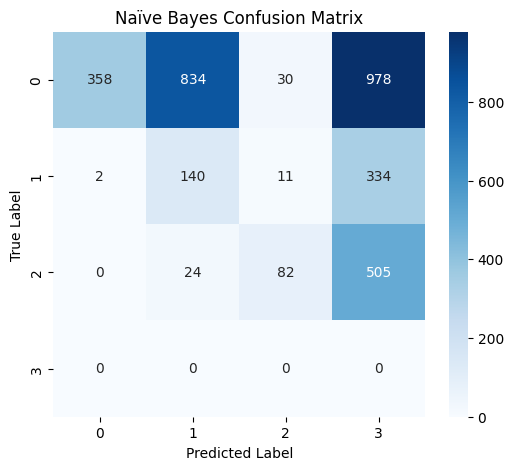

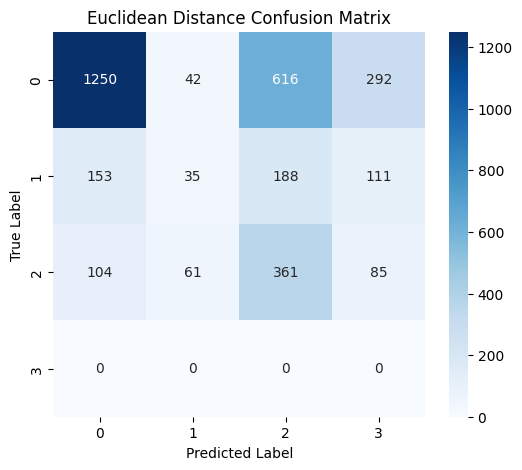

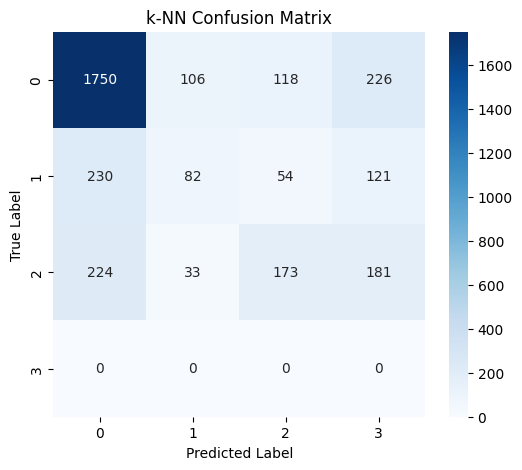

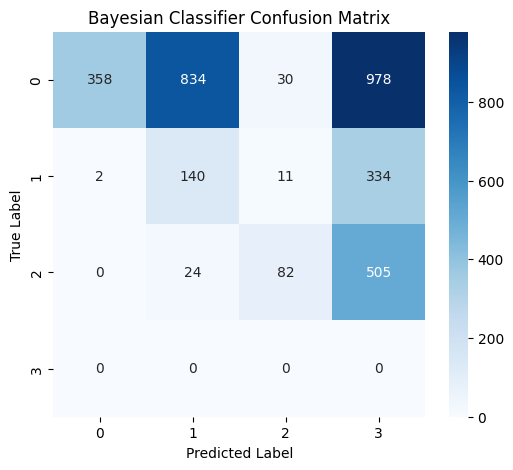

In [20]:
# Part 2: Classification
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

# Load classification labels
classification_labels = sio.loadmat('classification_labels_Salinas.mat')
training_labels = classification_labels['training_set'].flatten()[nonzero_indices[0]]  # Align with valid pixels
test_labels = classification_labels['test_set'].flatten()[nonzero_indices[0]]  # Align with valid pixels

# Prepare feature matrices using unmixing results
X_train = abundance_maps_lasso[training_labels > 0]
y_train = training_labels[training_labels > 0]

X_test = abundance_maps_lasso[test_labels > 0]
y_test = test_labels[test_labels > 0]

# 1. Naïve Bayes Classifier
from sklearn.model_selection import cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt

# Perform 10-fold cross-validation for Naïve Bayes
nb_cv_scores = cross_val_score(nb_classifier, X_train, y_train, cv=10)
nb_cv_mean = np.mean(nb_cv_scores)
nb_cv_std = np.std(nb_cv_scores)
print(f"Naïve Bayes Cross-Validation Accuracy: {nb_cv_mean:.4f} ± {nb_cv_std:.4f}")
nb_classifier = GaussianNB()
nb_classifier.fit(X_train, y_train)
nb_accuracy = accuracy_score(y_test, nb_classifier.predict(X_test))
nb_conf_matrix = confusion_matrix(y_test, nb_classifier.predict(X_test))

# 2. Minimum Euclidean Distance Classifier
from scipy.spatial.distance import cdist

def min_euclidean_distance_classifier(X_train, y_train, X_test):
    """Classify based on the minimum Euclidean distance to the mean of each class."""
    class_means = {c: np.mean(X_train[y_train == c], axis=0) for c in np.unique(y_train)}
    y_pred = []
    for x in X_test:
        distances = {c: np.linalg.norm(x - class_means[c]) for c in class_means}
        y_pred.append(min(distances, key=distances.get))
    return np.array(y_pred)

# Predict using Euclidean Distance Classifier
y_pred_euclidean = min_euclidean_distance_classifier(X_train, y_train, X_test)
euclidean_accuracy = accuracy_score(y_test, y_pred_euclidean)
euclidean_conf_matrix = confusion_matrix(y_test, y_pred_euclidean)
print(f"Minimum Euclidean Distance Accuracy: {euclidean_accuracy:.4f}")

# 3. k-Nearest Neighbors Classifier
knn_classifier = KNeighborsClassifier(n_neighbors=3)
knn_classifier.fit(X_train, y_train)
knn_accuracy = accuracy_score(y_test, knn_classifier.predict(X_test))
knn_conf_matrix = confusion_matrix(y_test, knn_classifier.predict(X_test))

# 4. Bayesian Classifier (GaussianNB)
from sklearn.naive_bayes import GaussianNB
bayes_classifier = GaussianNB()

# Perform 10-fold cross-validation for Bayesian Classifier
bayes_cv_scores = cross_val_score(bayes_classifier, X_train, y_train, cv=10)
bayes_cv_mean = np.mean(bayes_cv_scores)
bayes_cv_std = np.std(bayes_cv_scores)
print(f"Bayesian Classifier Cross-Validation Accuracy: {bayes_cv_mean:.4f} ± {bayes_cv_std:.4f}")

# Train and evaluate Bayesian Classifier
bayes_classifier.fit(X_train, y_train)
y_pred_bayes = bayes_classifier.predict(X_test)
bayes_accuracy = accuracy_score(y_test, y_pred_bayes)
bayes_conf_matrix = confusion_matrix(y_test, y_pred_bayes)
print(f"Bayesian Classifier Accuracy: {bayes_accuracy:.4f}")

# Display classification results
print(f"Naïve Bayes Accuracy: {nb_accuracy:.4f}")
print(f"Minimum Euclidean Distance Accuracy: {euclidean_accuracy:.4f}")
print(f"k-NN Accuracy: {knn_accuracy:.4f}")
print(f"Bayesian Classifier Accuracy: {bayes_accuracy:.4f}")
print(f"k-NN Accuracy: {knn_accuracy:.4f}")

# Confusion Matrix Visualization
def plot_confusion_matrix(conf_matrix, title):
    plt.figure(figsize=(6,5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Plot Confusion Matrices
plot_confusion_matrix(nb_conf_matrix, "Naïve Bayes Confusion Matrix")
plot_confusion_matrix(euclidean_conf_matrix, "Euclidean Distance Confusion Matrix")
plot_confusion_matrix(knn_conf_matrix, "k-NN Confusion Matrix")
plot_confusion_matrix(bayes_conf_matrix, "Bayesian Classifier Confusion Matrix")

# Fix Abundance Map Plotting
def plot_abundance_map_fixed(abundance_map, title, labels, nonzero_indices):
    """Fixes abundance map reshaping issue."""
    abundance_map_reshaped = np.zeros_like(labels, dtype=float)
    
    # Assign values correctly
    for idx, (x, y) in enumerate(zip(nonzero_indices[0], nonzero_indices[1])):
        abundance_map_reshaped[x, y] = abundance_map[idx, 0]  # Fixed indexing

    plt.figure(figsize=(6, 4))
    plt.imshow(abundance_map_reshaped, cmap='jet')
    plt.title(title)
    plt.colorbar()
    plt.show()



## Correlation Between Spectral Unmixing and Classification Results

### Overview
The spectral unmixing process estimates the abundance of different materials in each pixel of a hyperspectral image, while classification assigns each pixel to a specific class. Both methods analyze hyperspectral data but from different perspectives: unmixing focuses on decomposing mixed spectral signatures, while classification aims to label each pixel based on its dominant material.

### Observations on Correlation
#### 1. Impact of Abundance Maps on Classification
- The classification results rely on the abundance maps generated during spectral unmixing. If the unmixing step provides meaningful and well-separated abundance distributions, classifiers have a better chance of accurately distinguishing classes.
- LASSO-based unmixing yielded the lowest reconstruction error, suggesting it provides the most accurate abundance maps. This likely contributed to the relatively high accuracy of the k-NN classifier.

#### 2. Performance Trends
- The **k-NN classifier (60.73% accuracy)** performed better than Naïve Bayes and Bayesian classifiers (~26%), suggesting that local relationships in abundance data play a crucial role in classification.
- The **Minimum Euclidean Distance classifier (49.79% accuracy)** performed worse than k-NN but better than the probabilistic methods, indicating that class means alone may not capture sufficient spectral variability.

#### 3. Limitations of Probabilistic Classifiers
- Naïve Bayes and Bayesian classifiers assume independence among features, which is often **not valid for abundance maps** where endmembers can have correlated abundances.
- The poor performance of these methods suggests that spectral unmixing alone may not always provide fully separable class distributions, especially if materials have significant spectral overlap.

#### 4. Misclassification Patterns in the Confusion Matrices
- Classes with highly mixed pixels in spectral unmixing tend to have higher misclassification rates in classification.
- If a material's abundance is not well captured by unmixing, classifiers struggle to assign it correctly, leading to **higher off-diagonal values in confusion matrices**.

### Conclusion
The correlation between spectral unmixing and classification is strong, as the quality of unmixing directly influences classification accuracy. Higher-quality abundance maps lead to better class separation, but spectral overlap and unmixing errors can introduce classification challenges. The results indicate that hybrid approaches, combining unmixing with additional feature selection or dimensionality reduction, could further improve classification accuracy.
